In [96]:
import dataset
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
from torch.nn import Parameter
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import torch.nn.functional as F
from torch.autograd import Variable
#import torchviz

np.random.seed(1)
torch.manual_seed(1)


In [97]:

def rotation_matrix_to_quaternion(M):
#   Note: M must have positive determinant.

    Q = np.zeros(4)

    tr = M[0,0] + M[1,1] + M[2,2]
    if tr > 0.0: 
        s = 2.0 * math.sqrt(tr + 1.0)
        t = 1.0/s
        Q[0] = 0.25 * s
        Q[1] = (M[2,1] - M[1,2]) * t
        Q[2] = (M[0,2] - M[2,0]) * t
        Q[3] = (M[1,0] - M[0,1]) * t
    elif (M[0,0] > M[1,1]) and (M[0,0] > M[2,2]):
        s = 2.0 * math.sqrt(1.0 + M[0,0] - M[1,1] - M[2,2])
        t = 1.0/s
        Q[0] = (M[2,1] - M[1,2]) * t
        Q[1] = 0.25 * S
        Q[2] = (M[0,1] + M[1,0]) * t
        Q[3] = (M[0,2] + M[2,0]) * t
    elif M[1,1] > M[2,2]:
        s = 2.0 * math.sqrt(1.0 + M[1,1] - M[0,0] - M[2,2])
        t = 1.0/s
        Q[0] = (M[0,2] - M[2,0]) * t
        Q[1] = (M[0,1] + M[1,0]) * t
        Q[2] = 0.25 * s
        Q[3] = (M[1,2] + M[2,1]) * t
    else:
        s = 2.0 * math.sqrt(1.0 + M[2,2] - M[0,0] - M[1,1])
        t = 1.0/s
        Q[0] = (M[1,0] - M[0,1]) * t
        Q[1] = (M[0,2] + M[2,0]) * t
        Q[2] = (M[1,2] + M[2,1]) * t
        Q[3] = 0.25 * s
    
    return Q             

                 
def quaternion_to_rotation_matrix(Q):

    w = Q[0]
    x = Q[1]
    y = Q[2]
    z = Q[3]

    M = np.zeros((3,3))
    
    M[0,0] = 1.0 - 2.0*(y*y + z*z)
    M[0,1] = 2.0*(x*y - w*z)
    M[0,2] = 2.0*(x*z + w*y)

    M[1,0] = 2.0*(x*y + w*z)
    M[1,1] = 1.0 - 2.0*(x*x + z*z)
    M[1,2] = 2.0*(y*z - w*x)

    M[2,0] = 2.0*(x*z - w*y)
    M[2,1] = 2.0*(y*z + w*x)
    M[2,2] = 1.0 - 2.0*(x*x + y*y)

    return M
                 
    
                 
def random_rotation_matrix():
                 
    Q = np.random.randn(4)
    norm = np.linalg.norm(Q)

    if norm > 1e-7:
        Q = Q/norm
    else:
        Q = np.array([1.0, 0.0, 0.0, 0.0])
        
    M = quaternion_to_rotation_matrix(Q)
                
    return M
                 

In [98]:
root = os.getcwd()
NPT = 2**8

# choose dataset name from 'shapenetcorev2', 'shapenetpart', 'modelnet40' and 'modelnet10'
dataset_name = 'shapenetpart'

# choose split type from 'train', 'test', 'all', 'trainval' and 'val'
# only shapenetcorev2 and shapenetpart dataset support 'trainval' and 'val'
split = 'train'

d = dataset.Dataset(root=root, dataset_name=dataset_name, num_points=NPT, split=split, random_rotate=False)
print("datasize:", d.__len__())

item = 0
ps, lb, n, f = d[item]
print(ps.size(), ps.type(), lb.size(), lb.type(), n, f) 


datasize: 12137
torch.Size([256, 3]) torch.FloatTensor torch.Size([1]) torch.LongTensor airplane 02691156/points/d4d61a35e8b568fb7f1f82f6fc8747b8.pts


In [4]:
#torch.save(ps, 'tensor.pt')

In [3]:
ps = torch.load('tensor.pt')
NPT = ps
ps.shape[0]

tensor([[-0.7347,  0.0307,  0.0313],
        [ 0.9990, -0.0405, -0.0174],
        [-0.1660,  0.0177, -0.7674],
        ...,
        [ 0.2055, -0.0202,  0.0824],
        [ 0.1496, -0.0126, -0.1046],
        [-0.0722,  0.0075,  0.5724]])

In [99]:
def randrange(n, vmin, vmax):
    return (vmax - vmin)*np.random.rand(n) + vmin

def plot_points(pts):
    fig = plt.figure(dpi=150)
    ax = fig.add_subplot(111, projection='3d')


    xs = pts[:,0]
    ys = pts[:,1]
    zs = pts[:,2]
    cs = np.arange(pts.size()[0])
    ax.scatter(xs, ys, zs, s=0.1, c=cs, marker='o')

    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

    plt.show()

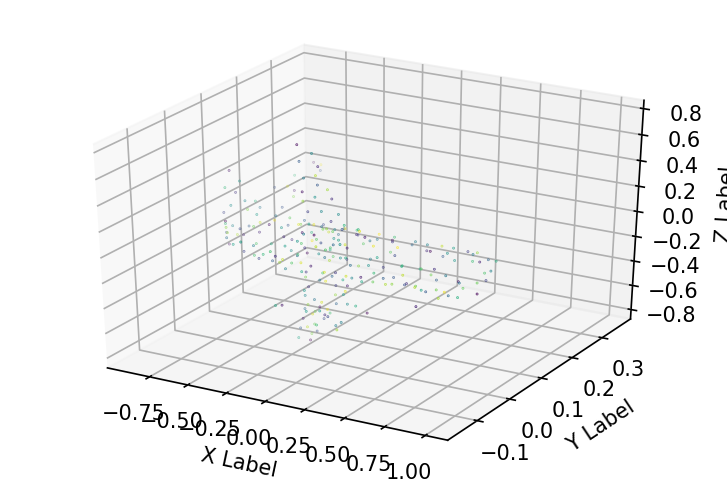

In [100]:
#M = torch.from_numpy( random_rotation_matrix() ).float()
#ps = torch.mm(ps, M)
plot_points(ps)

In [222]:
class CustomDataset(Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor
        
    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.x)


In [223]:

class SubclassFunctionalModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.hidden_linear = nn.Linear(1, 14)  
        self.output_linear = nn.Linear(14, 1)
        
    def forward(self, input):
        hidden_t = self.hidden_linear(input)
        activated_t = torch.tanh(hidden_t)
        activated_t = hidden_t
        output_t = self.output_linear(activated_t)
        
        return output_t


In [101]:
class STN3d(nn.Module):
    def __init__(self):
        super(STN3d, self).__init__()
        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 9)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)


    def forward(self, x):
        batchsize = x.size()[0]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

#         a = torch.from_numpy(np.array([1,0,0,0,1,0,0,0,1]).astype(np.float32))        
#         b = a.view(1,9).repeat(batchsize,1)
#         b.requires_grad = True
#         iden = Parameter(b)
        iden = Variable(torch.from_numpy(np.array([1,0,0,0,1,0,0,0,1]).astype(np.float32))).view(1,9).repeat(batchsize,1)
        if x.is_cuda:
            iden = iden.cuda()
        x = x + iden
        x = x.view(-1, 3, 3)
        return x


In [102]:
def training_loop(
    n_epochs, optimizer, model, loss_fn, train_loader, val_loader, device, 
    losses_train, losses_val, verbosity=None):

    for epoch in range(0, n_epochs):
        total_loss_train = 0.0
        n_batches_train = 0
        for x_train, y_train in train_loader:
            x_train = x_train.to(device)
            y_train = y_train.to(device)
            model.train()
            yhat_train = model(x_train)
            loss_train = loss_fn(y_train, yhat_train)
            total_loss_train += float(loss_train)
            n_batches_train += 1
#             print(y_train)
#             print(yhat_train)
#             print(loss_train)
#             print(n_batches_train)
            loss_train.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        total_loss_val = 0.0
        n_batches_val = 0
        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val = x_val.to(device)
                y_val = y_val.to(device)
                model.eval()
                yhat_val = model(x_val)
                loss_val = loss_fn(y_val, yhat_val)
                total_loss_val += float(loss_val)
                n_batches_val += 1
#                 print(n_batches_val)

        total_loss_train = total_loss_train/max(1,n_batches_train)
        total_loss_val = total_loss_val/max(1,n_batches_val)
        
        losses_train.append(total_loss_train)
        losses_val.append(total_loss_val)
        
        if verbosity is not None and epoch % verbosity == 0:
            print('Epoch {}, Training loss {}, Validation loss {}'.format(
                epoch, total_loss_train, total_loss_val))
            
        

In [103]:
#nsamples_train = 8
#nsamples_val = 2
#nsamples = nsamples_train + nsamples_val

#x = np.random.rand(nsamples,1)
#y = np.random.rand(nsamples,1)
#x_tensor = torch.from_numpy(x).float()
#y_tensor = torch.from_numpy(y).float()


In [118]:
size_batch = 1000
x_tensor = torch.zeros((size_batch, 3, ps.shape[0]))
y_tensor = torch.zeros((size_batch, 3, 3))

In [119]:
M = torch.zeros(3,3)
M[[0,1,2],[0,1,2]] = 1.0

for i in range(0,x_tensor.shape[0]):
    x_tensor[i] = torch.mm(ps, M).reshape(ps.shape[1], ps.shape[0])
    y_tensor[i] = M    
    M = torch.from_numpy( random_rotation_matrix() ).float()
    

In [120]:
size_val = size_batch//5
size_train = size_batch - size_val

dataset = TensorDataset(x_tensor, y_tensor)

train_dataset, val_dataset = random_split(dataset, [size_train, size_val])

train_loader = DataLoader(dataset=train_dataset, batch_size=min(16,size_train))
val_loader = DataLoader(dataset=val_dataset, batch_size=min(16,size_val))


# size_train = size_batch
# dataset = TensorDataset(x_tensor, y_tensor)
# train_dataset = dataset
# train_loader = DataLoader(dataset=train_dataset, batch_size=size_train)
# val_loader = None


In [107]:
#model = SubclassFunctionalModel()
model = STN3d()
#optimizer = optim.SGD(model.parameters(), lr=1e-2)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
loss_fn = nn.MSELoss(reduction='mean')
#model, optimizer, loss_fn
trainfig = plt.figure()


<Figure size 432x288 with 0 Axes>

In [121]:
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)

In [123]:
losses_train = []
losses_val = []
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
training_loop(
    10, optimizer, model, loss_fn, train_loader, val_loader, device, losses_train, losses_val, 1)

Epoch 0, Training loss 0.04398096084594726, Validation loss 0.0495056242037278
Epoch 1, Training loss 0.041469935104250906, Validation loss 0.04823722618703659
Epoch 2, Training loss 0.039172609187662605, Validation loss 0.04707026882813527
Epoch 3, Training loss 0.0370701177418232, Validation loss 0.04600119347182604
Epoch 4, Training loss 0.035141375213861466, Validation loss 0.04506986444959274
Epoch 5, Training loss 0.03336293794214726, Validation loss 0.04418558598710941
Epoch 6, Training loss 0.03172736059874296, Validation loss 0.04339995321172934
Epoch 7, Training loss 0.030219418480992317, Validation loss 0.04266807537239332
Epoch 8, Training loss 0.028823148161172867, Validation loss 0.04205573292878958
Epoch 9, Training loss 0.027528675571084023, Validation loss 0.04139570089486929


In [ ]:
with torch.no_grad():
    model.eval()
    M = model(x_tensor)
    print(y_tensor)
    print(M)
    print(float(loss_fn(y_tensor,M)))

In [ ]:
with torch.no_grad():
    k = 1
    model.eval()
    M = model(x_tensor[k].unsqueeze(0)).squeeze_()
    print(y_tensor[k])
    print(M)
    print(torch.mm(M,M.T))
    print(float(loss_fn(y_tensor[k],M)))

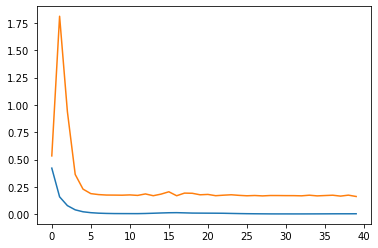

In [43]:
plt.plot(losses_train)
plt.plot(losses_val)

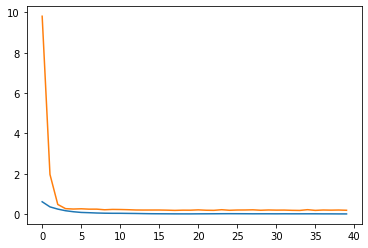

In [46]:
plt.plot(losses_train)
plt.plot(losses_val)

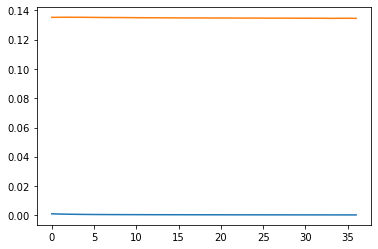

In [60]:
plt.plot(losses_train[3:])
plt.plot(losses_val[3:])

In [82]:
M = torch.from_numpy( random_rotation_matrix() ).float()
xM = torch.mm(ps, M).reshape(ps.shape[1], ps.shape[0])
model.eval()
Mhat = model(xM.unsqueeze(0)).squeeze_()   
print(M)
print(Mhat)
print(float(loss_fn(M,Mhat)))

tensor([[ 0.3892,  0.6947,  0.6049],
        [-0.1633,  0.6983, -0.6969],
        [-0.9066,  0.1724,  0.3852]])
tensor([[ 0.4816,  0.7307,  0.1511],
        [-0.0362,  0.4037, -0.5794],
        [-0.6134,  0.3624,  0.1952]], grad_fn=<SqueezeBackward2>)
0.05451874062418938
